In [3]:
library(ggplot2)

library(survival)

library(cowplot)

library("survminer")

library(ggfortify)

library(survminer)
library(preprocessCore)

library(scProcess)
library(ggpubr)

library(preprocessCore)


In [4]:
runSuv=function(all,gs,fout,magnitude.norm=NULL,normalize.quantiles=NULL,cancer=''){
    exp=all$rpkm
    ano=all$survival
    inter=intersect(colnames(exp),rownames(ano))
    exp=exp[,inter]
    ano=ano[inter,]
  
  if (!is.null(normalize.quantiles)){   #
    print('normalize.quantiles')
    exp2=normalize.quantiles(as.matrix(exp))
    colnames(exp2)=colnames(exp)
    rownames(exp2)=rownames(exp)
    exp=exp2
  }
    
   # dim(exp)
   # dim(ano)
    ids=as.numeric(apply(data.frame(colnames(exp)),1,function(x) substr(x, 14, 15)))
   # table(ids)
    
    indexT=ids<10
    indexN=ids>10
    
    dat=exp[,indexT]  # remove adjacent normal 
    ann=ano[indexT,]
    ann$time=as.numeric(ann$X_OS)
    ann$vital_status=ann$X_EVENT
    
                  
                         
    gs=intersect(gs,rownames(exp))
    
    if (length(gs)==1){
      score=as.numeric(dat[gs,])
    }else{
      tmp=dat[gs,]
      print(tmp[,1:4])
      if (!is.null(magnitude.norm)){
        tmp=apply(tmp,2,function(x) x/max(x))
      }
      score=scale(rowMeans(t(tmp)))  # avearge expression 
    }
    
  #  print(summary(score))

    res=data.frame(ann,'exp'=score)
    
    
    cut1=quantile(res$exp,0.75)
    cut2=quantile(res$exp,0.25)
    
    res1=res[res$exp>=cut1,]
    res2=res[res$exp<cut2,]
    
    fn1=paste(fout,'-High',sep='')
    fn2=paste(fout,'-Low',sep='')
    
    res2$x=fn2
    res1$x=fn1 #'High-exp'
    
    res=rbind(res1,res2)
    
    fit <- surv_fit(Surv(time, vital_status) ~ x, data = res)
    
    pvalue=survdiff(Surv(time, vital_status)~x, data=res)
    p2=round(1-pchisq(pvalue$chisq,1),4)
    p0=NULL
    p0=ggsurvplot(fit, pval = p2,linetype = c("solid", "dashed"), #
                  palette = c("red","blue"),title=cancer, #paste(gs,p2),
                  legend.title="",legend.labs=c(fn1,fn2),xlab='Months', pval.coord = c(0, 0.1),
                  conf.int = F) 
    
    return(res)
}
                  
                  
                  
readData=function(tcancer,normalize.quantiles=NULL){
  fin=paste0('/d0/home/meisl/Workplace/TCGA/RDS/',tcancer,'.rds',sep='')[[1]]
  all=readRDS(fin)
    exp=all$rpkm
    ano=all$survival
    inter=intersect(colnames(exp),rownames(ano))
    exp=exp[,inter]
    ano=ano[inter,]
    
    if (!is.null(normalize.quantiles)){   #
      exp2=normalize.quantiles(as.matrix(exp))
      colnames(exp2)=colnames(exp)
      rownames(exp2)=rownames(exp)
      exp=exp2
    }
    
    
    ids=as.numeric(apply(data.frame(colnames(exp)),1,function(x) substr(x, 14, 15)))
    # table(ids)
    
    indexT=ids<10
    indexN=ids>10
    
    dat=exp[,indexT]  # remove adjacent normal 
    ann=ano[indexT,]
    ann$time=as.numeric(ann$X_OS)
    ann$time = ann$time/30
    ann$vital_status=ann$X_EVENT
    
  return(list('exp'=dat,'ano'=ann)  ) 
}



samSuv=function(dat,gs,fout='',magnitude.norm=NULL,plot=NULL,colf = c("red","blue")){
  exp=dat[['exp']]
  ann=dat[['ano']]
  gs=intersect(gs,rownames(exp))
  
  if (length(gs)==1){
    score=as.numeric(exp[gs,])
  }else{
    tmp=exp[gs,]
    if (!is.null(magnitude.norm)){
      tmp=apply(tmp,2,function(x) x/max(x))
    }
    score=scale(rowMeans(t(tmp)))  # avearge expression 
  }
  
  #  print(summary(score))
  
  res=data.frame(ann,'exp'=score)
  back=res
  
  cut1=quantile(res$exp,0.75)
  cut2=quantile(res$exp,0.25)
  
  res1=res[res$exp>=cut1,]
  res2=res[res$exp<cut2,]
  
  fn1=paste(fout,'-High',sep='')
  fn2=paste(fout,'-Low',sep='')
  
  res2$x=fn2
  res1$x=fn1 #'High-exp'
  
  res=rbind(res1,res2)
  
  fit <- surv_fit(Surv(time, vital_status) ~ x, data = res)
  
  pvalue=survdiff(Surv(time, vital_status)~x, data=res)
  p2=1-pchisq(pvalue$chisq,1)
  p0=NULL
  
  if (!is.null(plot)){
    p0=ggsurvplot(fit, pval = round(p2,4),linetype = c("solid", "dashed"), #
                  palette = colf,#title=cancer, #paste(gs,p2),
                  legend.title="",xlab='Days', pval.coord = c(0, 0.1),
                  conf.int = F) 
    print(p0)
    }

  #surv_summary(fit)
  return(list('fit2'=surv_summary(fit),'p2'=p2,'p0'=p0))
  
}

In [20]:
# MSC-2 signatures
tcancer='KIRC'

gs = c('COL6A2','FN1','TIMP1','COL3A1','COL1A2')

title = 'MSC-2'


Warning message in .get_data(x, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


[1] "KIRC"
[1] 0.003708063
       90% 
0.02286245 


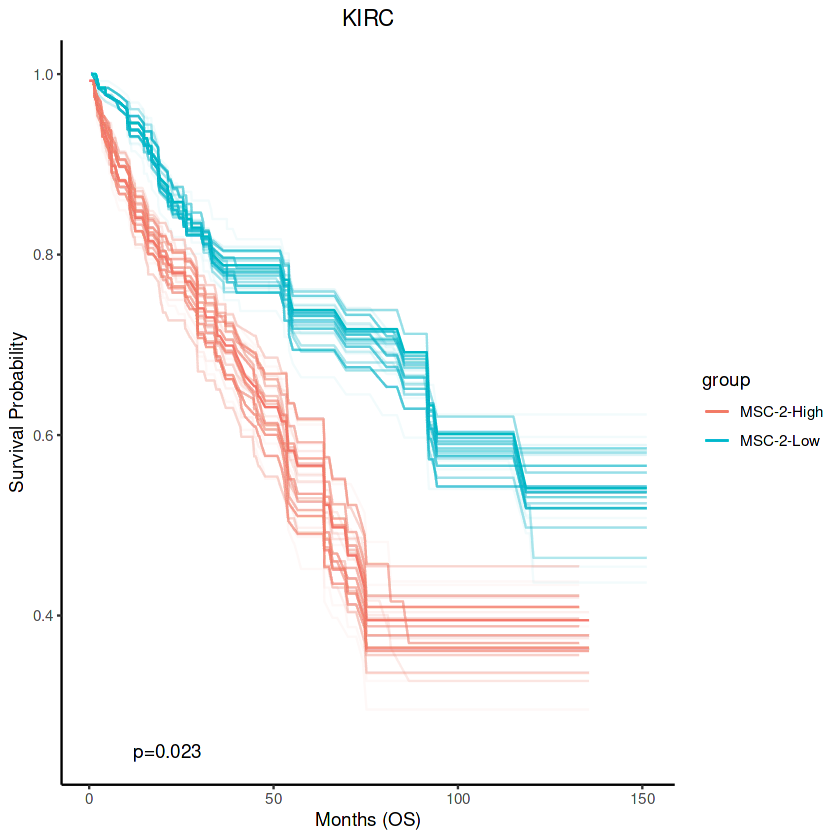

In [21]:
iterm = 200

dat=readData(tcancer,normalize.quantiles=TRUE)
df=samSuv(dat,gs,fout=title)
print(tcancer)
print(df$p2)



lis <- mclapply(sn(seq(iterm)), function(x) {

    gs1=sample(gs,length(gs),replace = TRUE)
    samSuv(dat,gs1,fout=title)
},mc.cores=20)


pval.list=unlist(lapply(lis,function(x) x$p2))
pval=quantile(pval.list,0.90)
print(pval)


p=ggplot(df$fit2, aes(x=time, y=surv,color=x)) +theme_classic()+ylab('Survival Probability')+xlab('Months (OS)')+ggtitle(tcancer)+
geom_line()+ guides(color=guide_legend("group"))+  theme(plot.title = element_text(hjust = 0.5))+
annotate("text", x =quantile(df$fit2$time,0.3), y = 0.25, label = paste('p=',round(pval,3),sep=''))
#p

for (n in names(lis)){
tmp=lis[[n]]$fit2
p=p+geom_line(data=tmp, aes(x=time, y=surv,color=x),alpha=0.05)
}
p



Warning message in .get_data(x, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


[1] "KIRC"
[1] 1.101489e-05
       90% 
0.02559378 


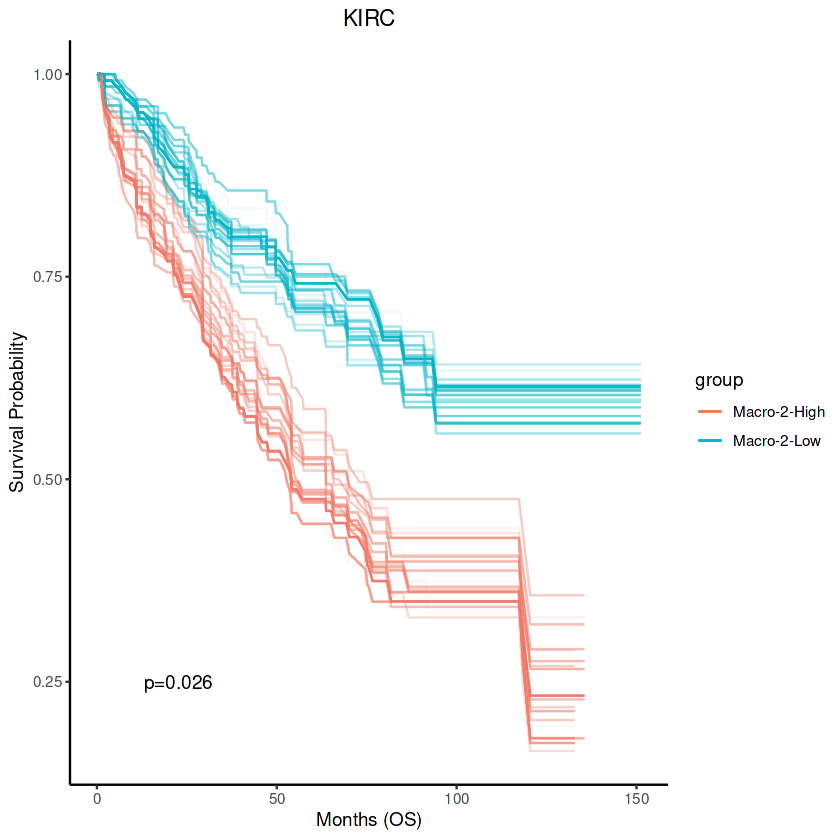

In [17]:
# Macro-2 signatures

gs=c('TREM2','FABP5','CCL18','CXCL5','CCL7','SPP1')

title = 'Macro-2'


iterm = 200

dat=readData(tcancer,normalize.quantiles=TRUE)
df=samSuv(dat,gs,fout=title)
print(tcancer)
print(df$p2)
  
  

lis <- mclapply(sn(seq(iterm)), function(x) {

    gs1=sample(gs,length(gs),replace = TRUE)
    samSuv(dat,gs1,fout=title)
},mc.cores=20)


pval.list=unlist(lapply(lis,function(x) x$p2))
pval=quantile(pval.list,0.90)
print(pval)


p=ggplot(df$fit2, aes(x=time, y=surv,color=x)) +theme_classic()+ylab('Survival Probability')+xlab('Months (OS)')+ggtitle(tcancer)+
geom_line()+ guides(color=guide_legend("group"))+  theme(plot.title = element_text(hjust = 0.5))+
annotate("text", x =quantile(df$fit2$time,0.3), y = 0.25, label = paste('p=',round(pval,3),sep=''))
#p

for (n in names(lis)){
tmp=lis[[n]]$fit2
p=p+geom_line(data=tmp, aes(x=time, y=surv,color=x),alpha=0.05)
}
p
ggsave(paste(tcancer,'.',title,'..new.TAM95.pdf',sep=''),p,height=3,width=4.3)


In [10]:
source('/home/meisl/Workplace/TCGA/TCGA.function.R')


In [11]:
# compare gene expression in TCGA data

[1] "normalize.quantiles"



TRUE 
 605 

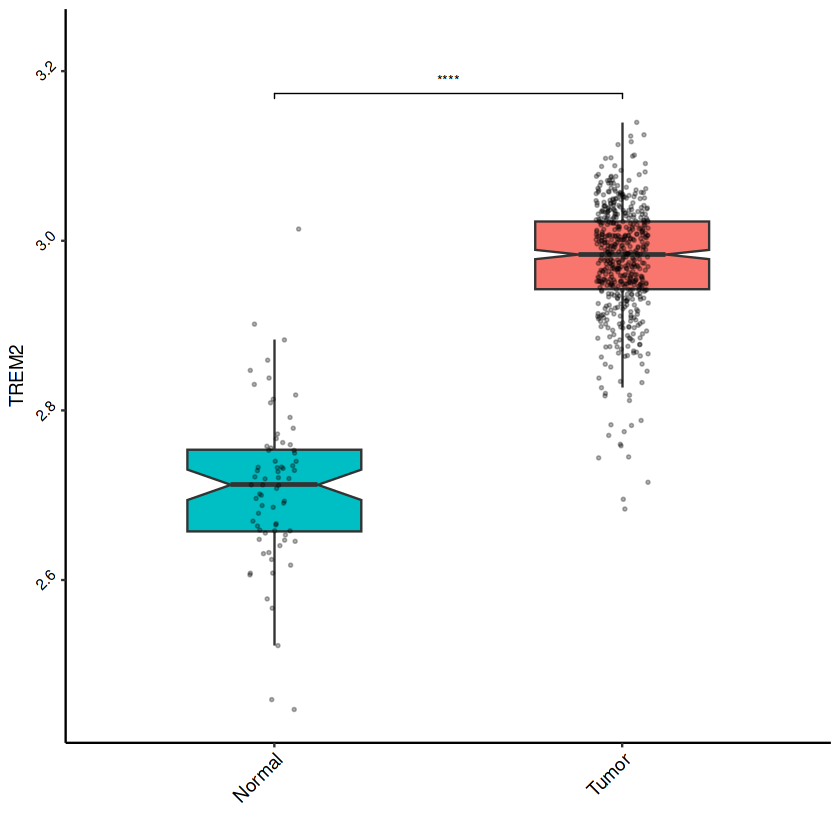

In [13]:
cancer = 'KIRC'


res = getTCGA.data(cancer)


ids = res$ids
exp = res$exp
table(names(ids)==colnames(exp))


gene ='TREM2'
    
df2  =  data.frame('cell'=factor(ids,levels=c('Normal','Tumor')),'fraction'=factor(ids,levels=c('Normal','Tumor')),'score'=as.numeric(exp[gene,]))

p=drawBoxplot(paste(gene,cancer),df2,gene,myeloid.col=c('#00BFC4','#F8766D'),limHeight=1.03,height=2.1,width=1.6,notch = TRUE)#,dsize=0.1
#p=p+ ggpubr::stat_compare_means(label = "p.signif", label.x = 1.5)
p



In [14]:
table(ids)

ids
Normal  Tumor 
    72    533 